In [1]:
!pip install snntorch --quiet
!pip install scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.3 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import torch
from torch.utils.data import DataLoader, Dataset

class EEGDataset(Dataset):

    def __init__(self, path):

        ####################
        ### Loading data ###
        ####################

        mat = loadmat(path, struct_as_record=True, squeeze_me=True, mat_dtype=False)

        #################################
        ### Setting up the properties ###
        #################################

        self.estimuli = {
                1 : "A",
                2 : "E",
                3 : "I",
                4 : "O",
                5 : "U",
                6 : "Arriba",
                7 : "Abajo",
                8 : "Adelante",
                9 : "Atrás",
                10 : "Derecha",
                11 : "Izquierda"
            }

        # Modalities
        self.modalities = {
            1 : "Imaginada",
            2 : "Falada"
        }

        # Artfacts
        self.artfacts = {
            -1 : "Indiferente",
            1 : "Com artefato",
            2 : "Sem artefato"
        }

        self.dataframe = pd.DataFrame(mat['EEG'])

        # Creates 6 channels of EEG data
        self.channels = 6
        self.channelsLength = 4096
        self._joinIntoArray(0, 4096, 'F3', self.dataframe)
        self._joinIntoArray(0, 4096, 'F4', self.dataframe)
        self._joinIntoArray(0, 4096, 'C3', self.dataframe)
        self._joinIntoArray(0, 4096, 'C4', self.dataframe)
        self._joinIntoArray(0, 4096, 'P3', self.dataframe)
        self._joinIntoArray(0, 4096, 'P4', self.dataframe)

        # Creates 3 more channels:
        # labels 'Estímulo'
        # artifacts 'Modalidade' and 'Artefatos'
        self._joinIntoValue(0, 1, 'Modalidade', self.dataframe)
        self._joinIntoValue(0, 1, 'Estímulo', self.dataframe)
        self._joinIntoValue(0, 1, 'Artefatos', self.dataframe)

        self.filteredData = self.dataframe[(self.dataframe['Modalidade'] == 1) & (self.dataframe['Artefatos'] == 1)]

        self.labels = self.filteredData['Estímulo'].values
        self.data = self.filteredData[['F3','F4','C3','C4','P3','P4']].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample_data =  torch.tensor(self.data[idx].tolist(),dtype=torch.float) # Convert numpy arrays to tensors
        sample_label = torch.tensor(self.labels[idx].tolist(),dtype=torch.float)  # Ensure labels are also tensors
        return sample_data, sample_label

    # Auxiliary methods
    def _joinIntoArray(self, start_col, end_col, newColumn, dataframe):
        cols_to_join = dataframe.iloc[:, start_col:end_col].columns
        dataframe[newColumn] = dataframe[cols_to_join].apply(lambda x: np.array(pd.to_numeric(x, errors='coerce')), axis=1)
        dataframe.drop(cols_to_join, axis=1, inplace=True)

    def _joinIntoValue(self, start_col, end_col, newColumn, dataframe):
        cols_to_join = dataframe.iloc[:, start_col:end_col].columns
        dataframe[newColumn] = dataframe[cols_to_join].apply(lambda x: pd.to_numeric(x, errors='coerce'), axis=1)
        dataframe.drop(cols_to_join, axis=1, inplace=True)

<ipython-input-7-a55fa9aad39e>:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  sample_data =  torch.tensor(self.data[idx].tolist(),dtype=torch.float) # Convert numpy arrays to tensors


Epoch 0, Iteration 2 
Train max/min loss: 9853.03/344.07
Epoch 0, Iteration 4 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 6 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 8 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 10 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 12 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 14 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 16 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 18 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 20 
Train max/min loss: 14861.26/344.07
Epoch 0, Iteration 22 
Train max/min loss: 14861.26/344.07
Epoch 1, Iteration 2 
Train max/min loss: 14861.26/36.08
Epoch 1, Iteration 4 
Train max/min loss: 14861.26/36.08
Epoch 1, Iteration 6 
Train max/min loss: 14861.26/36.08
Epoch 1, Iteration 8 
Train max/min loss: 14861.26/36.08
Epoch 1, Iteration 10 
Train max/min loss: 14861.26/36.08
Epoch 1, Iteration 12 
Train max/min loss: 14861.26/36.08
Epoch 1, Ite

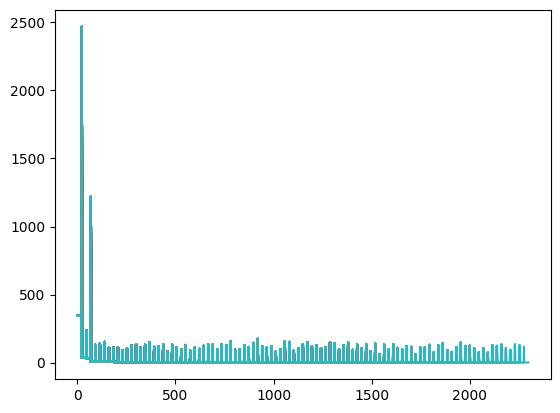

In [8]:
import math
import torch
import torch.nn as nn
# from data import EEGDataset
from torch import nn, save, load
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler

import matplotlib.pyplot as plt

# Define a simple neural network architecture with dynamic size calculation
class EEGNet(nn.Module):
    def __init__(self, input_channels, input_timepoints):
        super(EEGNet, self).__init__()

        ############################################################
        ######## Calculates the size of the feature vector #########
        ############################################################

        # Calculate the size of the features after the 1st conv and pool layers
        feature_size = self.get_tensor_size_after_conv(input_timepoints,5)
        feature_size = self.get_tensor_size_after_maxpool(feature_size,2)
        # Calculate the size of the features after the 2nd conv and pool layers
        feature_size = self.get_tensor_size_after_conv(feature_size,5)
        feature_size = self.get_tensor_size_after_maxpool(feature_size,2)
        # Calculate the size of the features after the flatten
        feature_size = feature_size * 32


        ################################
        ###### Creates the model #######
        ################################

        self.model = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=5),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten(),
            nn.Linear(feature_size, 128),
            nn.ReLU(),
            nn.Linear(128, 27)
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def save_model(self, path):
        with open(path, 'wb') as f:
            save(self.state_dict(), f)

    def load_model(self, path):
        with open(path, 'rb') as f:
            self.load_state_dict(load(f))

    def get_tensor_size_after_conv(self, input_size, convolution_kernel_size):
        return 1 +(input_size - convolution_kernel_size)

    def get_tensor_size_after_maxpool(self, input_size, poll_kernel_size):
        return math.floor(input_size / poll_kernel_size)

# Create the neural network
test_size = 0.2
batch_size = 10
num_epochs = 100
device = torch.device("cuda")
data_path='/content/drive/MyDrive/databases/S01_EEG.mat'
# device = torch.device("cpu")
# data_path='S01_EEG.mat'

# Create DataLoaders
eegDataset = EEGDataset(data_path)

# Create model
model = EEGNet(eegDataset.channels, eegDataset.channelsLength)
model.to(device)

# Optmizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.1, 0.999))
loss_fn = nn.CrossEntropyLoss()

# Ensures that the networks runs with floats
model.float()

# Get the indices for the entire dataset
dataset_size = len(eegDataset)
indices = list(range(dataset_size))

# Split the indices into training and validation sets
train_indices, test_indices = train_test_split(indices, test_size=test_size, random_state=42, shuffle=True)

# Create SubsetRandomSamplers for training and validation
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders using the SubsetRandomSamplers
train_loader = DataLoader(eegDataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(eegDataset, batch_size=batch_size, sampler=test_sampler)


# Loss and accuracy history
min_loss_hist = [] # record loss over iterations

# Keeps the minimum loss
minLoss = 1000000

# Keeps the maximum loss
maxLoss = 0

# Training loop
for epoch in range(num_epochs):

    # Retrieve batch
    iteration = 0;
    trainning_batch = iter(train_loader)

    for data, targets in trainning_batch:

        # More one iteration
        iteration += 1

        # Get data and labels
        data = data.to(device)
        targets = targets.to(device)

        # forward-pass
        model.train() # Enable tranning mode on model
        spk_rec = model(data) # The forward pass itself

        loss_val = torch.zeros(1, dtype=torch.float, device=device)
        loss_val += loss_fn(spk_rec.sum(1).squeeze(), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad() # null gradients
        loss_val.backward() # calculate gradients
        optimizer.step() # update weights

        # Keeps track of the max and min loss
        if maxLoss < loss_val.item() :
            maxLoss = loss_val.item()
        if minLoss > loss_val.item() :
            minLoss = loss_val.item()

        if iteration == 1 :
          min_loss_hist.append(loss_val.item()) # store loss
        else :
          min_loss_hist.append(minLoss) # store loss

        # print every 10 iterations
        if iteration % 2 == 0:
            print(f"Epoch {epoch}, Iteration {iteration} \nTrain max/min loss: {maxLoss:.2f}/{minLoss:.2f}")

    plt.plot(min_loss_hist)

model.save_model('cnn.pth')
# model.load_model('test.pth')

Epoch 0, Iteration 2 
Train max/min loss: 233.41/114.54
Epoch 0, Iteration 4 
Train max/min loss: 233.41/114.54
Epoch 0, Iteration 6 
Train max/min loss: 233.41/104.29
Epoch 0, Iteration 8 
Train max/min loss: 233.41/104.29
Epoch 0, Iteration 10 
Train max/min loss: 233.41/90.08
Epoch 0, Iteration 12 
Train max/min loss: 233.41/90.08
Epoch 0, Iteration 14 
Train max/min loss: 233.41/90.08
Epoch 0, Iteration 16 
Train max/min loss: 233.41/90.08
Epoch 0, Iteration 18 
Train max/min loss: 233.41/90.08
Epoch 0, Iteration 20 
Train max/min loss: 233.41/90.08
Epoch 0, Iteration 22 
Train max/min loss: 233.41/90.08
Epoch 0, Iteration 24 
Train max/min loss: 233.41/90.08
Epoch 1, Iteration 2 
Train max/min loss: 233.41/90.08
Epoch 1, Iteration 4 
Train max/min loss: 233.41/90.08
Epoch 1, Iteration 6 
Train max/min loss: 233.41/90.08
Epoch 1, Iteration 8 
Train max/min loss: 233.41/90.08
Epoch 1, Iteration 10 
Train max/min loss: 233.41/90.08
Epoch 1, Iteration 12 
Train max/min loss: 233.41/81

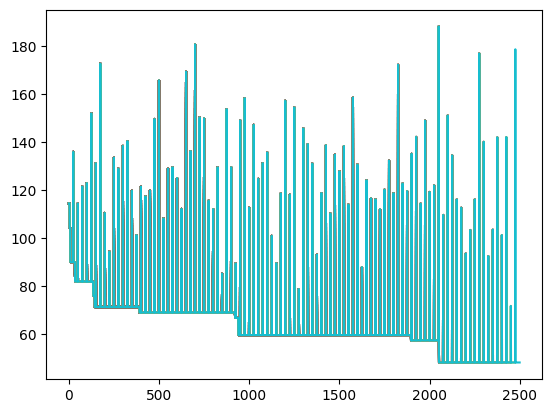

In [9]:
import math
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from torch import nn, save, load
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from snntorch import utils
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import snntorch.functional as SF
import matplotlib.pyplot as plt
# from data import EEGDataset

class SNNModel(nn.Module):
    def __init__(self, inputLength, insist = 4, neuronDecayRate = 0.9):
        super(SNNModel, self).__init__()

        self.insist = insist
        spike_grad = surrogate.fast_sigmoid() # fast sigmoid surrogate gradient

        ################################
        ###### Creates the model #######
        ################################

        self.model = nn.Sequential(
            nn.Linear(inputLength, 4096),
            snn.Leaky(beta=neuronDecayRate, spike_grad=spike_grad),
            nn.Linear(4096, 27),
            snn.Leaky(beta=neuronDecayRate, spike_grad=spike_grad),
            nn.AvgPool1d(27, stride=1)
        )

    def save_model(self, path):
        with open(path, 'wb') as f:
            save(self.state_dict(), f)

    def load_model(self, path):
        with open(path, 'rb') as f:
            self.load_state_dict(load(f))


    def forward(self, x):
        mem1 = self.model[1].init_leaky()
        mem2 = self.model[3].init_leaky()

        spk2_rec = []
        mem2_rec = []

        for step in range(self.insist):
            inputCurrent = self.model[0](x)
            spk1, mem1 = self.model[1](inputCurrent, mem1)

            inputSpikes = self.model[2](spk1)
            spk2, mem2 = self.model[3](inputSpikes, mem2)

            avg = self.model[4](spk2)

            spk2_rec.append(avg)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)
# Configuration section
insist = 4
test_size = 0.2
batch_size = 10
num_epochs = 100
neuronDecayRate = 0.9
device = torch.device("cuda")
data_path='/content/drive/MyDrive/databases/S01_EEG.mat'
# device = torch.device("cpu")
# data_path='/home/ensismoebius/Documentos/UNESP/doutorado/databases/Base de Datos Habla Imaginada/S01/S01_EEG.mat'


# Set random seed for reproducibility
torch.manual_seed(42)

# Create DataLoaders
eegDataset = EEGDataset(data_path)

# Get the indices for the entire dataset
dataset_size = len(eegDataset)
indices = list(range(dataset_size))

# Split the indices into training and validation sets
train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=42, shuffle=True)

# Create SubsetRandomSamplers for training and validation
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders using the SubsetRandomSamplers
train_loader = DataLoader(eegDataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(eegDataset, batch_size=batch_size, sampler=test_sampler)

# Create network object
model = SNNModel(
    inputLength=eegDataset.channelsLength,
    insist=insist,
    neuronDecayRate=neuronDecayRate
)
model.to(device)
# Ensures that the networks runs with floats
model.float()
# Initialize lif weights
utils.reset(model)

# Optmizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, betas=(0.1, 0.999))
loss_fn = nn.CrossEntropyLoss()

# Loss and accuracy history
min_loss_hist = [] # record loss over iterations

# Keeps the minimum loss
minLoss = 1000000

# Keeps the maximum loss
maxLoss = 0

# Training loop
for epoch in range(num_epochs):

    # Retrieve batch
    trainning_batch = iter(train_loader)
    iteration = 0;

    for data, targets in trainning_batch:

        # More one iteration
        iteration += 1

        # Get data and labels
        data = data.to(device)
        targets = targets.to(device)

        # forward-pass
        model.train() # Enable tranning mode on model
        spk_rec, _ = model(data) # The forward pass itself

        loss_val = torch.zeros(1, dtype=torch.float, device=device)
        loss_val += loss_fn(spk_rec.sum(2).sum(0).squeeze(), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad() # null gradients
        loss_val.backward() # calculate gradients
        optimizer.step() # update weights

        # Keeps track of the max and min loss
        if maxLoss < loss_val.item() :
            maxLoss = loss_val.item()
        if minLoss > loss_val.item() :
            minLoss = loss_val.item()

        if iteration == 1 :
          min_loss_hist.append(loss_val.item()) # store loss
        else :
          min_loss_hist.append(minLoss) # store loss

        # print every 10 iterations
        if iteration % 2 == 0:
            print(f"Epoch {epoch}, Iteration {iteration} \nTrain max/min loss: {maxLoss:.2f}/{minLoss:.2f}")

    plt.plot(min_loss_hist)

model.save_model('spik.pth')
# model.load_model('test.pth')